In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import requests
import pandas as pd
from filter_data import *

In [6]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera
from IPython.display import HTML

import importlib
import warnings
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from filter_data import *
from load_and_clean import *
import hdbscan
%matplotlib inline

In [7]:
from load_and_clean import *

#update_data()

#us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple = load_clean('mobility Apple')
mobility_data_google, google_social = load_clean('mobility Google')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

ctp_us_data = load_clean('CTP US')
ctp_state_data = load_clean('CTP states')
ctp_state_pop_adjusted = {stat: create_population_adjusted_data(data, all_population, show_exception=False) for stat, data in ctp_state_data.items()}

C:\Users\wangy\Github\synthetic_control_analysis\load_and_clean.py:218: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  county_population = pd.read_csv(_county_pop_local_path, header=[3], skipfooter=6)


These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Burma', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'MS Zaandam', 'North Macedonia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Syria', 'Taiwan*', 'West Bank and Gaza', 'Western Sahara']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Bristol Bay plus Lake and Peninsula-Alaska', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puerto Rico', 'Cayey-Pue

In [8]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

#all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data = pd.concat([usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

#all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases = pd.concat([uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

#all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop = pd.concat([uscases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)
#deaths_intervention_adjusted_google, deaths_intervention_adjusted_daily_google, _ = create_intervention_adjusted_data(all_data, google_social, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

hospitalized_pop_adjusted, hospitalized_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['hospitalizedCurrently'], educational_distancing, t, ignore_nan=True)
icu_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['inIcuCurrently'], educational_distancing, t, ignore_nan=True)
ventilator_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['onVentilatorCurrently'], educational_distancing, t, ignore_nan=True)


last date
Exceptions are []


#### Note: I use the vaccine data from https://github.com/owid/covid-19-data/tree/master/public/data/vaccinations

In [9]:
data = pd.read_csv("us_state_vaccinations.csv")
total = data.pivot(index = 'date', columns = 'location', values = 'people_fully_vaccinated_per_hundred')
total = total.rename(columns={'New York State':'New York'})
total = total[set(uscases.columns).intersection(set(total.columns))]
vaccine_intervention = pd.DataFrame(total.apply(pd.Series.first_valid_index))
vaccine_intervention = vaccine_intervention.reset_index()
vaccine_intervention.columns = ["name", "date"]
total = total.fillna(0)

In [10]:
feature_dict, features = cluster_time_series(total.loc["2021-01-19":], cluster_method = 'kmeans', n_clusters = 4)
colors = get_colors(len(feature_dict), picker = 2)

## Cluster analysis of the trend

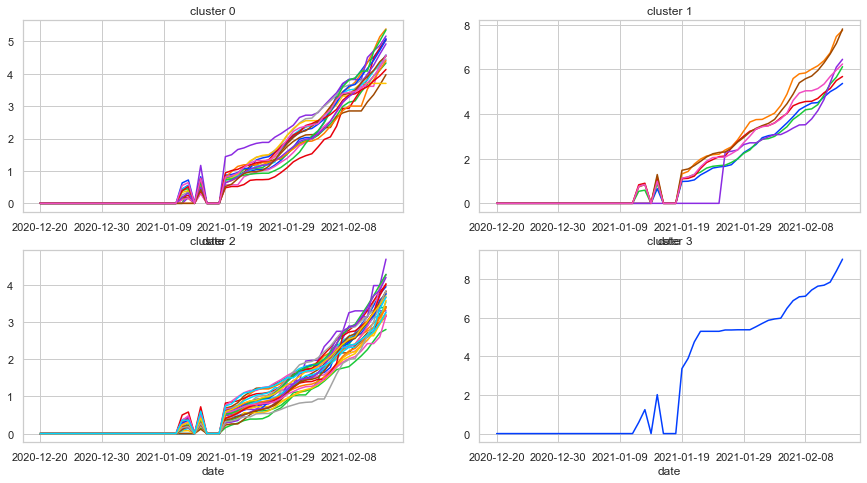

In [11]:
i = 321
for key in feature_dict:
    ax = plt.subplot(i)
    i += 1
    total[feature_dict[key]].plot(ax = ax, legend=False, figsize = (15, 12), title = "cluster %s" %(key))

In [28]:
feature_dict

{0: Index(['Oklahoma', 'Connecticut', 'Arkansas', 'Florida',
        'District of Columbia', 'Minnesota', 'Oregon', 'Tennessee', 'Maine',
        'Nebraska', 'Colorado', 'Hawaii', 'Louisiana', 'Rhode Island',
        'Michigan', 'New Hampshire', 'Montana'],
       dtype='object', name='location'),
 1: Index(['Vermont', 'West Virginia', 'New Mexico', 'South Dakota', 'Guam',
        'Alaska', 'North Dakota'],
       dtype='object', name='location'),
 2: Index(['New Jersey', 'Delaware', 'Virgin Islands', 'Illinois', 'Utah',
        'Puerto Rico', 'California', 'North Carolina', 'Nevada', 'Pennsylvania',
        'Virginia', 'Kansas', 'Alabama', 'Texas', 'Wyoming', 'Ohio', 'Indiana',
        'Iowa', 'Georgia', 'South Carolina', 'Massachusetts', 'Arizona',
        'New York', 'Wisconsin', 'Kentucky', 'Maryland', 'Idaho', 'Mississippi',
        'Washington', 'Missouri'],
       dtype='object', name='location'),
 3: Index(['Northern Mariana Islands'], dtype='object', name='location')}

### The plot for different cluster
It seems that the trend after the vaccine is distributed is similar for all cluster (except the 'Northern Mariana Islands' which should be an outlier).

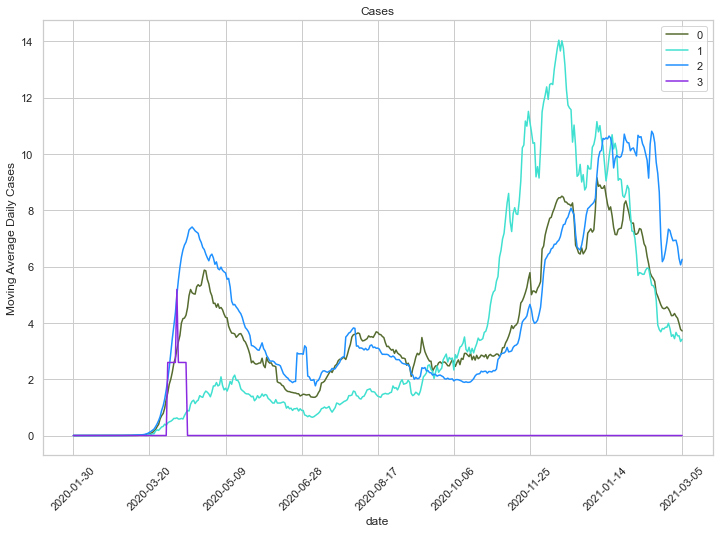

In [12]:
plt.rcParams['figure.figsize'] = (12, 8)
dfplot=all_data_daily
i=0
for key in feature_dict:
    group = feature_dict[key]
    temp = []
    for county in group:
        if county in dfplot.columns:
            temp.append(county)
    (1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label = key, c = colors[i])
    #(1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label=group_labels[i])
    plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases'), plt.title('Cases'), plt.legend()
    i=i+1
plt.show()

### What if the vaccine is distributed earlier

I did similar analysis as we have done for lockdown date. Specifically I am realign the dataframe based on the date that the vaccine is distributed, and see the if the trend of the cases will change. The donor pools are set based on the cluster analysis. The following example is for new york, which is in cluaster 0.

In [33]:

case_vaccine_adjusted, case_vaccine_adjusted_daily, _= create_intervention_adjusted_data(all_cases_data_pop, vaccine_intervention, 7, ignore_nan=False)

In [34]:

targets = ['New York']# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 4
lambdas = [1]
donors = list(set(list(feature_dict[0])).intersection(set(all_cases_data_pop_daily.columns)))


for target in targets:
    fig, axes = plt.subplots(figsize=(16,6))
    camera = Camera(fig)
    
    for i in range(1,15):

        temp_df, date = filter_data_by_intervention(all_cases_data_pop_daily[[target]], vaccine_intervention, i)

        return_value = synth_control_predictions([pd.concat([case_vaccine_adjusted_daily,temp_df], axis=1)], 40,22, "7-day moving average of daily cases", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12, svdSpectrum = False, donorPool = donors,
                                   exclude=[target, 'China-Hubei'], animation=camera, figure=fig, axes=[axes], showDonors=False, silent=True, showPlots=True, error_thresh=8000, FONTSIZE=14)
        #error_thresh=3
        

    animation = camera.animate()

animation.save('New York new.mp4')
plt.close('all')
HTML(animation.to_html5_video())



